<center> <b><font size = 6>
    Penguins Classification
    <b/><center/>

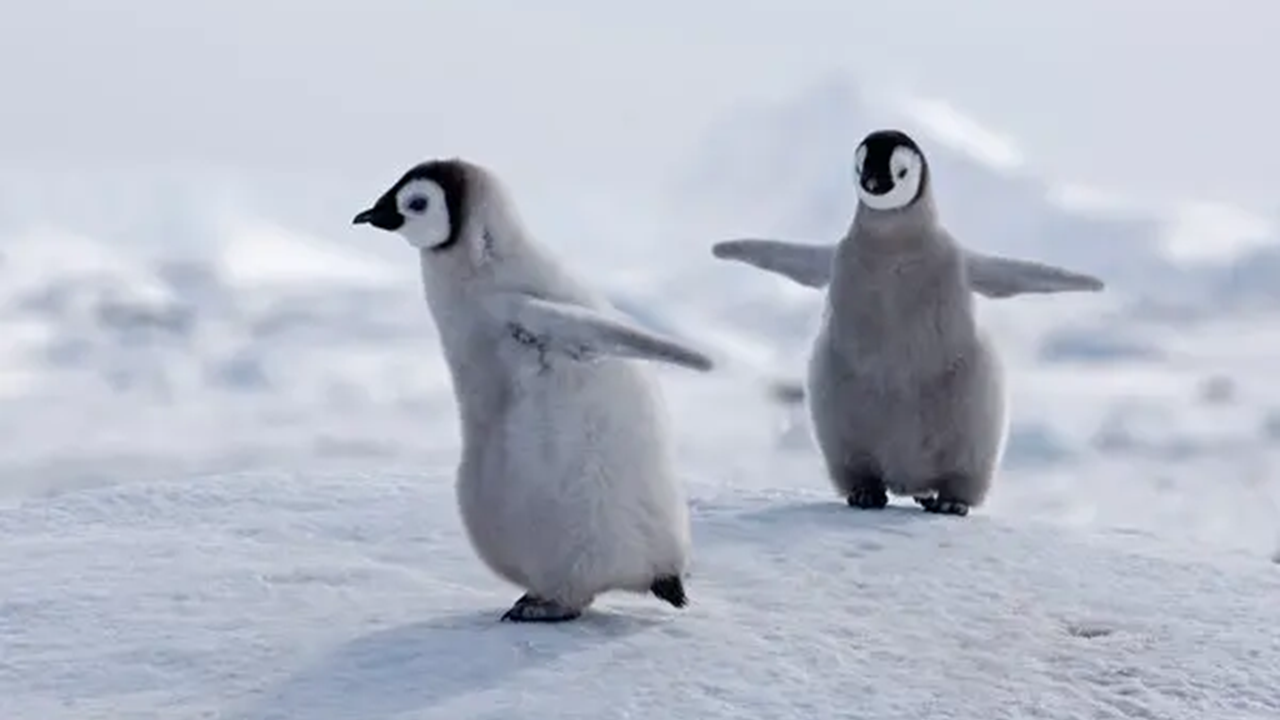

In [1]:
from IPython.display import display, Image
display(Image(r'C:\Users\domingosdeeularia\...\PenguinsCover.png'))

## Summary

## Main Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('ggplot')

# Preprocessing and training
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Function to retrieve candidate models evaluation metrics
from eval_models.eval_models import eval_class


# Ignoring warnings
from warnings import filterwarnings as fw
fw('ignore')

## Data Preparation

In [3]:
# Importing the dataset

file = r'C:\Users\domingosdeeularia\...\PenguinsDataset.csv'
df = pd.read_csv(file)
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
# Info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
# Addressing missing values

num_cols = list(df.iloc[:, 2:-1].columns)

cols_transf = ColumnTransformer(transformers = [
                                ('num', SimpleImputer(strategy = 'median'), num_cols),
                                ('cat', SimpleImputer(strategy = 'most_frequent'), ['sex'])
                                ])
df[df.columns[2:]] = cols_transf.fit_transform(df)

In [6]:
# Rechecking existence of missing values

df.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [7]:
# Rechecking data types

df.dtypes

species              object
island               object
culmen_length_mm     object
culmen_depth_mm      object
flipper_length_mm    object
body_mass_g          object
sex                  object
dtype: object

In [8]:
# Converting numerical types

for col in num_cols:
    df[col] = df[col].astype(float)
df.dtypes

species               object
island                object
culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [9]:
# Counting unique values on categorical columns

cat_cols = list(set(df.columns) - set(num_cols))
df[cat_cols].value_counts()

island     sex     species  
Biscoe     MALE    Gentoo       65
           FEMALE  Gentoo       58
Dream      FEMALE  Chinstrap    34
           MALE    Chinstrap    34
                   Adelie       29
Torgersen  MALE    Adelie       28
Dream      FEMALE  Adelie       27
Torgersen  FEMALE  Adelie       24
Biscoe     FEMALE  Adelie       22
           MALE    Adelie       22
           .       Gentoo        1
Name: count, dtype: int64

In [10]:
# Replacing the '.' value in sex column with the mode

no_sex_cell = lambda sex: df.sex.value_counts().index[0] if sex not in ('MALE', 'FEMALE') else sex 
df['sex'] = df.sex.map(no_sex_cell)
df.sex.value_counts()

sex
MALE      179
FEMALE    165
Name: count, dtype: int64

## Exploratory Data Analysis

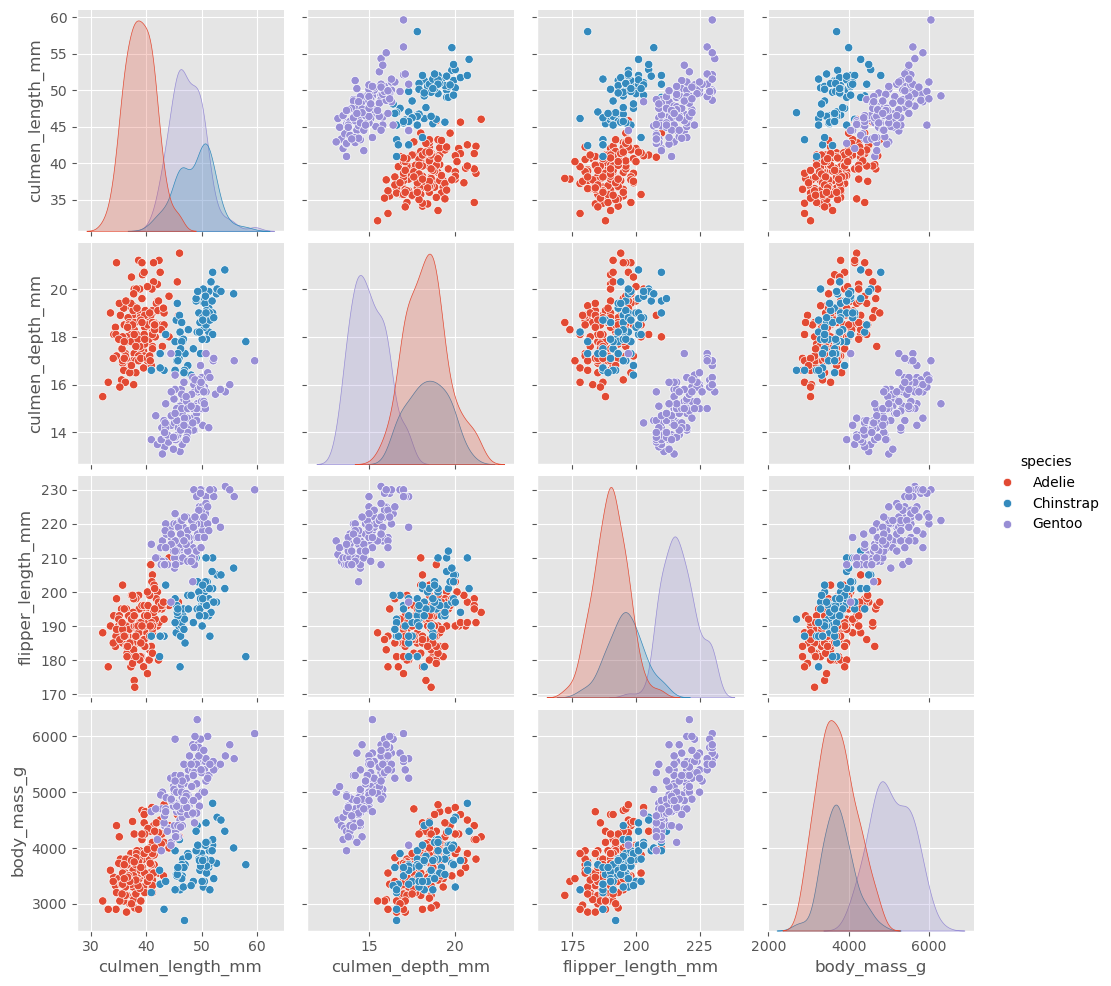

In [11]:
# Pairplot of penguins features

sns.pairplot(df, hue = 'species')
plt.show()

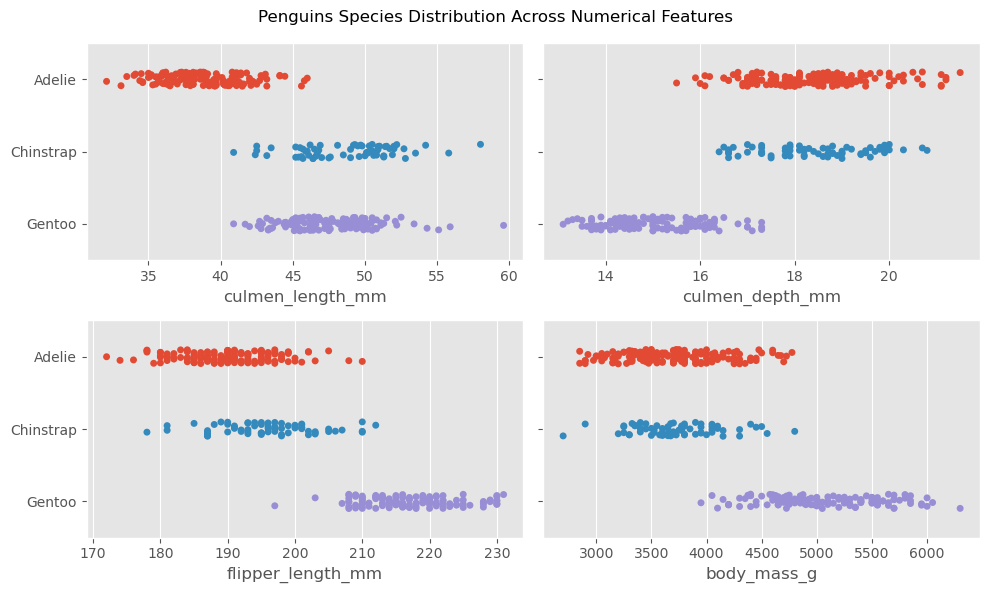

In [12]:
# Plot for numerical features

fig, axs = plt.subplots(nrows = 2, ncols = 2, sharey = True, figsize = (10, 6))
for i, ax in enumerate(axs.flatten()):
    sns.stripplot(data = df, x = num_cols[i], y = 'species', hue = 'species', ax = ax)
    ax.set_ylabel('')
plt.suptitle('Penguins Species Distribution Across Numerical Features')
plt.tight_layout()
plt.show()

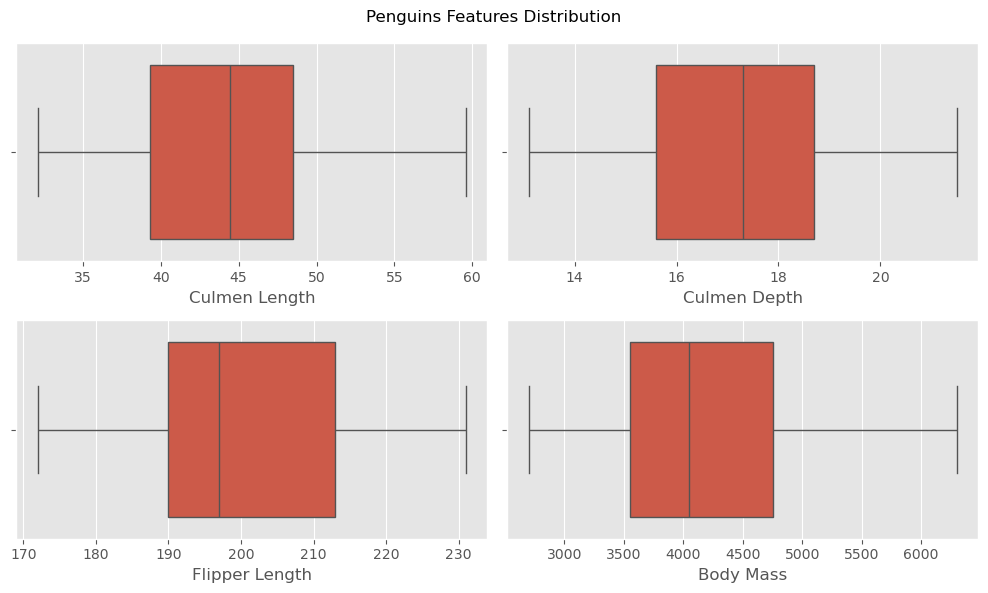

In [13]:
# Boxplots for numerical features

fig, axs = plt.subplots(nrows = 2, ncols = 2, sharey = True, figsize = (10, 6))
for i, ax in enumerate(axs.flatten()):
    sns.boxplot(data = df, x = num_cols[i], ax = ax)
    ax.set_ylabel('')
    ax.set_xlabel(num_cols[i].strip('_gm').replace('_', ' ').title())
plt.suptitle('Penguins Features Distribution')
plt.tight_layout()
plt.show()

## Model Training

In [14]:
# Target and predictors

y, X = df['species'], df.drop(columns = ['species'])
X = pd.get_dummies(X, drop_first = True)

In [15]:
# Dimensionality reduction for plotting

X_scaled = StandardScaler().fit_transform(X)
X_scaled = PCA(2).fit_transform(X_scaled)
df_pca = pd.DataFrame(X_scaled, columns = ['P. Component 1', 'P. Component 2'])
df_pca['species'] = y

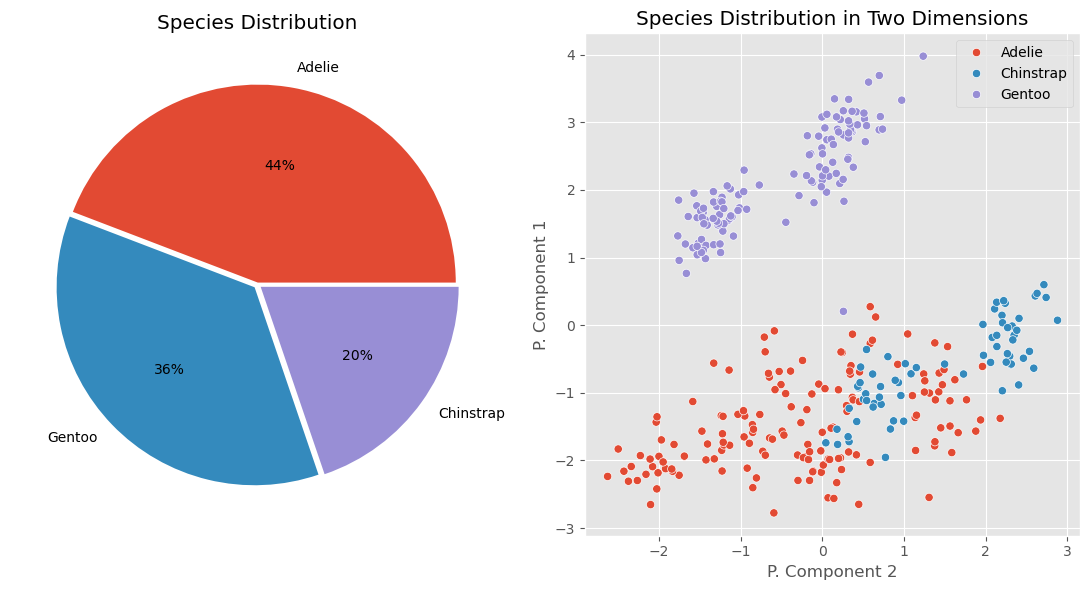

In [16]:
# Analysing species balance in the dataset

fig, axes = plt.subplots(ncols = 2, figsize = (11, 6))

df.species.value_counts().plot.pie(autopct = '%.f%%', explode = (0.01, 0.02, 0.02), ax = axes[0])
axes[0].set_ylabel('')
axes[0].set_title('Species Distribution')
sns.scatterplot(data = df_pca, y = 'P. Component 1', x = 'P. Component 2', hue = 'species', ax = axes[1])
axes[1].legend()
axes[1].set_title('Species Distribution in Two Dimensions')
plt.tight_layout()
plt.show()

In [17]:
# Number of penguins by species

df.species.value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

In [18]:
# Oversampling with ADASYN to address class imbalance

seed = 7
adasyn = ADASYN(random_state = seed)

X_bal, y_bal = adasyn.fit_resample(X, y)
y_bal.value_counts()

species
Chinstrap    160
Adelie       152
Gentoo       152
Name: count, dtype: int64

In [19]:
# Encoding the output variable (species)

y_bal_enc = pd.Series(LabelEncoder().fit_transform(y_bal), name = 'species')
y_bal_enc.value_counts()

species
1    160
0    152
2    152
Name: count, dtype: int64

In [20]:
# Splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal_enc, test_size = 0.3, random_state = seed)

In [21]:
# Dictionary of candidate models and their instances

log_reg, tree_clf = LogisticRegression(random_state = seed), DecisionTreeClassifier(random_state = seed)

forest_clf = RandomForestClassifier(random_state = seed)

candidate_models = {'Logistic Regression': log_reg, 
                    'Decision Tree': tree_clf, 'Random Forest': forest_clf}

In [22]:
# Scores evaluation

scores, best_model_pipeline = eval_class(candidate_models, X_train, y_train)
scores

,Model,Mean Score (F1 Micro)
1,Decision Tree,0.981490
2,Random Forest,0.981442
0,Logistic Regression,0.857981


In [23]:
# Best model pipeline

best_model_pipeline

Pipeline(steps=[('feature selection',
                 RFE(estimator=DecisionTreeClassifier(random_state=7))),
                ('classifier', DecisionTreeClassifier(random_state=7))])

In [24]:
# Fittng the best model and making predictions

best_model = best_model_pipeline.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred

array([0, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 0,
       1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 1, 0,
       2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2,
       2, 0, 1, 2, 2, 1, 2, 2])

In [25]:
# Evaluation metrics

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.98      0.98      0.98        52
           2       0.96      0.98      0.97        44

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



In [26]:
# Binarizing the outputs

y_bin_test = LabelBinarizer().fit_transform(y_test)
y_bin_pred = LabelBinarizer().fit_transform(y_pred)

In [27]:
# Outputs probability and AUC Score (micro average)

y_pred_prb = best_model.predict_proba(X_test)
auc_micro = roc_auc_score(y_bin_test.flatten(), y_pred_prb.flatten())

In [28]:
# Micro fpr and tpr

FPR, TPR = dict(), dict()
FPR['micro'], TPR['micro'], _ = roc_curve(y_bin_test.flatten(), y_pred_prb.flatten())

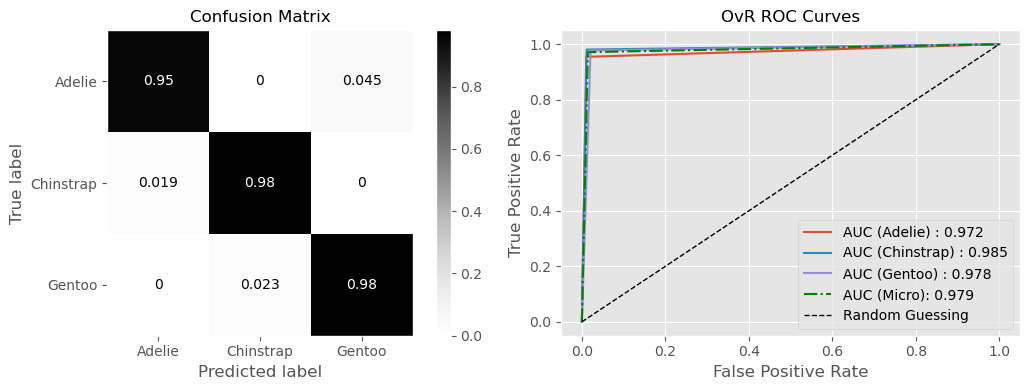

In [29]:
# Plots for Confusion Matrix and ROC-AUC


fig, axes = plt.subplots(figsize = (11, 4), ncols = 2)

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis = 1)[:, np.newaxis]
roc_auc_score_ = roc_auc_score(y_bin_test, y_bin_pred)
n_classes = list(np.unique(y))
ConfusionMatrixDisplay(conf_matrix_norm).plot(cmap = 'Greys', ax = axes[0])
axes[0].set_title('Confusion Matrix', fontsize = 12)
axes[0].set_xticks(ticks = np.unique(y_pred), labels = n_classes)
axes[0].set_yticks(ticks = np.unique(y_pred), labels = n_classes)
axes[0].grid(False)

# Plotting the AUC-ROC Curve
fpr, tpr = dict(), dict()
for i in range (len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_pred_prb[:, i])
    roc_auc_score_i = roc_auc_score(y_bin_test[:, i], y_pred_prb[:, i])
    plt.plot(fpr[i], tpr[i], label = f'AUC ({n_classes[i]}) : {roc_auc_score_i:.3f}')
plt.plot(FPR['micro'], TPR['micro'], 'g-.', label = f'AUC (Micro): {auc_micro:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', linewidth = 1)
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].legend(loc = 'lower right')
axes[1].set_title('OvR ROC Curves', fontsize = 12)
plt.tight_layout()
plt.show()

##  Data Provenance

<p>
  <strong>Source:</strong> 
  Michael Waskom (GitHub) 
  <a href = 'https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv' target = '_blank'>
    Penguin Dataset.
  </a>
  <br>
  <strong>License:</strong>
    <a href = 'https://allisonhorst.github.io/palmerpenguins/LICENSE.html' target = '_blank'>
        CC0.
    </a>
    <br><br>
  <em>Last accessed on October, 16 2024.</em>
</p>

                 ________  ________   _______   ______
                 /_  __/ / / / ____/  / ____/ | / / __ \
                  / / / /_/ / __/    / __/ /  |/ / / / /
                 / / / __  / /___   / /___/ /|  / /_/ /
                /_/ /_/ /_/_____/  /_____/_/ |_/_____/  
